Back to the main [Index](../index.ipynb)

# Phonons and Born effective charges with Abinit and AbiPy

This lesson shows how to compute phonon band structures, phonon DOSes 
and Born effective charges with Abinit and AbiPy.
The dicussion closely follows the [second lesson](http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/lesson_rf2.html)
on response functions available on the Abinit web-site.  
Let us assume that you have read the litterature relative to the [first lesson](http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/lesson_rf1.html)
on response functions.

You might find additional material, related to the present section, in the following references: 

   * X. Gonze and C. Lee, Phys. Rev. B55, 10355 (1997), especially section IX 
   * C. Lee, X. Gonze, Phys. Rev. B 51, 8610 (1995) 
   * S. Baroni, S. de Gironcoli, A. Dal Corso, P. Giannozzi, Rev. Mod. Phys. 73, 515 (2001).
   
Note that, unlike many of the previous lessons, in this case we do not provide any `lesson`
object that hides the internal implementation.
In this lesson, you are supposed to explore the Abipy objects interactively either inside ipython 
or in the ipython notebook.

# Creating the input for the SCF-GS run

Before starting, we need to import the python modules and the functions we will need 
for our studies. In particular, we need the `make_scf_input` function defined
in `abipy.lessons.lesson_dfpt`:

In [1]:
# Use %matplotlib if you are running in the ipython shell.
%matplotlib notebook

from __future__ import print_function, division

from abipy import abilab
from abipy.tools.notebooks import print_source
import abipy.flowapi as flowapi

from abipy.lessons.lesson_dfpt import make_scf_input

`make_scf_input` returns an `AbinitInput`, a python object with the Abinit variables
needed to perform a ground-state calculation for crystalline $AlAs$.
Let's have a look at the signature of the function:

In [2]:
help(make_scf_input)

Help on function make_scf_input in module abipy.lessons.lesson_dfpt:

make_scf_input(ecut=2, ngkpt=(4, 4, 4))
    This function constructs an `AbinitInput` for performing a 
    GS-SCF calculation in crystalline AlAs.
    
    Args:
        ecut: cutoff energy in Ha.
        ngkpt: 3 integers specifying the k-mesh for the electrons.
    
    Return:
        `AbinitInput` object



The docstring tells us that if we call `make_scf_input` without arguments, we get a input object
for computing the ground-state of $AlAs$ with `ecut=2` and `ngkpt=(4, 4, 4)`.
Let's try:

In [3]:
scf_input = make_scf_input()
print(scf_input)

############################################################################################
#                                      SECTION: varbas                                      
############################################################################################
# <Energy CUToff>
 ecut 2
# <SHIFT for K points>
 shiftk
    0.0    0.0    0.5
    0.0    0.5    0.0
    0.5    0.0    0.0
    0.5    0.5    0.5
# <Number of Grid points for K PoinTs generation>
 ngkpt 4 4 4
# <Number of BANDs>
 nband 4
# <TOLerance on the potential V(r) ReSidual>
 tolvrs 1e-10
# <Integer for eXchange-Correlation choice>
 ixc 1
# <Number of (non-)self-consistent field STEPS>
 nstep 25
# <Number of SHIFTs for K point grids>
 nshiftk 4
############################################################################################
#                                       SECTION: vargs                                      
################################################################################

Note that `make_scf_input` makes some assumption for important parameters such as the
the crystalline structure and the pseudos to be used. 
If you want to change these parameters (e.g. the pseudos), you have to write your version of `make_scf_input`.

It's less complicated than you think. Let's have a look at the code:

In [4]:
print_source(make_scf_input)

As you can see, `make_scf_input` is just initializing the `AbinitInput` object 
with a hardcoded list of pseudos and lattice parameters taken from an internal database.

`AbinitInput` is a dict-like object and the `set_vars` function sets the values of the 
Abinit variables needed for the GS-SCF run. 
It should not be so difficult to generalize the code to take into account other cases.

In the next paragraphs, we will show how to use `scf_input` to generate more complicated 
flows for DFPT calculations. 
More specifically, we'll discuss how to

   * Perform a converge study for the phonon frequencies at $\Gamma$ as function of `ecut`
   * Compute the full phonon band structure of `AlAs` with the inclusion of Born 
     effective charges

# Convergence study for the phonon frequencies at $\Gamma$ as function of `ecut`

In this section, we use `scf_input` as a starting point to build more 
complicated DFPT calculations. 
AbiPy, indeed, provides several factory functions to costruct `Flows` from an 
initial `AbinitInput` object
(a `Flow` is a set of Abinit `Tasks` connected by dependencies).

These factory functions accept optional parameters that can be used to customize the flow.
The function `phonon_conv_flow`, for example, builds and returns a `Flow` that performs 
a phonon calculation on a given set of $q$-points.

Let's use `scf_input` and `phonon_conv_flow`, to perform a convergence study for 
the phonons at `qpt=(0,0,0)` for different values of `ecut`: 

<IPython.core.display.Javascript object>


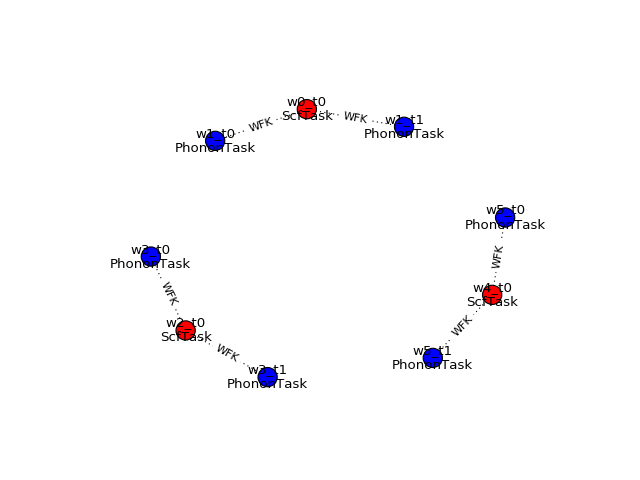

In [5]:
flow = flowapi.phonon_conv_flow("flow_alas_ecut_conv", scf_input, qpoints=(0, 0, 0), 
                                params=["ecut", [4, 6, 8]])

flow.plot_networkx(with_edge_labels=True)

The flow generated by `phonon_conv_flow` contains three independent groups of tasks, one group per each value of `ecut` specified in `params`.
Each group consists of one `ScfTask` that solves the `KS` equations self-consistently and produces a WFK file.
This `ScfTask` is the parent of two `PhononTasks` that will use the WFK file produced by `ScfTask`
to compute the first-order change of the wavefunctions due to one of the *irreducible* atomic pertubations.
This explains why we have two `PhononTasks` per $q$-point instead of the total number of phonon modes that equals $3*N_{atom}=6$. 
Note that `phonon_conv_flow` invokes Abinit under the hood to get the list of irreducible perturbations and uses this information to build the flow.

Now we can start the calculation with the scheduler.


In [6]:
%%capture
# discards the output in ipython notebooks
flow.make_scheduler().start()

0

The scheduler blocks until the entire `Flow` is completed.
You will have to wait a bit before proceeding with the next steps!

In [7]:
flow.show_summary()


Status       Count
---------  -------
Completed        9

<Flow, node_id=81286, workdir=flow_alas_ecut_conv>, num_tasks=9, all_ok=True



The calculation is completed and there are several output files located inside the 
`outdata` directories.
Let's print a table with all the DDB files (a.k.a. Derivative Database) 
produced by our `Flow`:

In [8]:
flow.listext("DDB")

Found 12 files with extension DDB produced by the flow
File                                            Size [Mb]    Node_ID  Node Class
--------------------------------------------  -----------  ---------  ------------
flow_alas_ecut_conv/w0/t0/outdata/out_DDB            0.01      81288  ScfTask
flow_alas_ecut_conv/w1/outdata/out_DDB               0.02      81289  PhononWork
flow_alas_ecut_conv/w1/t0/outdata/out_DDB.nc         0         81291  PhononTask
flow_alas_ecut_conv/w1/t1/outdata/out_DDB.nc         0         81292  PhononTask
flow_alas_ecut_conv/w2/t0/outdata/out_DDB            0.01      81294  ScfTask
flow_alas_ecut_conv/w3/outdata/out_DDB               0.02      81295  PhononWork
flow_alas_ecut_conv/w3/t0/outdata/out_DDB.nc         0         81297  PhononTask
flow_alas_ecut_conv/w3/t1/outdata/out_DDB.nc         0         81298  PhononTask
flow_alas_ecut_conv/w4/t0/outdata/out_DDB            0.01      81300  ScfTask
flow_alas_ecut_conv/w5/outdata/out_DDB               0.02    

We are mainly interested in the DDB files located in the `outdata` directories of the `PhononWorks`.
These are indeed the DDB files with all the information needed to reconstruct the 
dynamical matrix at $\Gamma$ and to compute the phonon frequencies (AbiPy calls `mrgddb`
to merge the DDB files when all the perturbations in the `PhononWork` have been computed).

Remember that our goal is to analyze the convergence of the phonon frequencies at $\Gamma$ 
as function of `ecut`. 
In principle, one should run `anaddb` with the different DDB files, extract the data from the output files, gather the results in another file and finally plot the results.
This is the lengthy procedure we have been using for years but now we have the abipy robots that
will do most of the boring work in a semi-automated way.

The code below tells our robot that we would like to analyze all the DDB files located in the output directories of the works:

In [9]:
robot = abilab.DdbRobot.from_flow(flow, outdirs="work")
robot

DdbRobot with 3 files in memory
  [0] flow_alas_ecut_conv/w1/outdata/out_DDB
  [1] flow_alas_ecut_conv/w3/outdata/out_DDB
  [2] flow_alas_ecut_conv/w5/outdata/out_DDB

At this point we can ask the `DdbRobot` to create a `Pandas` table (a.k.a. `DataFrame`) 
with the phonon frequencies and the parameters of the calculations in tabular form: 

In [10]:
frame = robot.get_dataframe_at_qpoint((0, 0, 0))

For a quick introduction to Pandas, see:

   * [A practical introduction to IPython Notebook & pandas](http://nbviewer.ipython.org/github/jvns/talks/blob/master/pydatanyc2013/PyData%20NYC%202013%20tutorial.ipynb)
   * [Diving into Open Data with IPython Notebook & Pandas](http://nbviewer.ipython.org/github/jvns/talks/blob/master/pyconca2013/pistes-cyclables.ipynb)

The `DataFrame` is a dict-like object whose keys are the name of the colums in the table

In [11]:
print(list(frame.keys()))

[u'mode4', u'mode5', u'mode2', u'mode3', u'mode0', u'mode1', u'ixc', u'ecut', u'tsmear', u'nsppol', u'nkpt', u'formula', u'natom', u'angle0', u'angle1', u'angle2', u'a', u'b', u'c', u'volume', u'abispg_num', u'spglib_symb', u'spglib_num']


To show the data in tabular form:

In [12]:
frame

,mode4,mode5,mode2,mode3,mode0,mode1,ixc,ecut,tsmear,nsppol,...,angle0,angle1,angle2,a,b,c,volume,abispg_num,spglib_symb,spglib_num
flow_alas_ecut_conv/w1/outdata/out_DDB,0.043641,0.043641,0,0.043641,0,0,1,4,0.01,1,...,60,60,60,3.970101,3.970101,3.970101,44.247584,0,F-43m,216
flow_alas_ecut_conv/w3/outdata/out_DDB,0.044485,0.044485,0,0.044485,0,0,1,6,0.01,1,...,60,60,60,3.970101,3.970101,3.970101,44.247584,0,F-43m,216
flow_alas_ecut_conv/w5/outdata/out_DDB,0.044625,0.044625,0,0.044625,0,0,1,8,0.01,1,...,60,60,60,3.970101,3.970101,3.970101,44.247584,0,F-43m,216


where `mode(i)` is the frequency in eV of the i-th phonon mode.

The frame created by the robot contains several columns.
Many of them are not useful in this case since 
we are mainly interested in the convergence of the frequencies with respect to `ecut`. 
Fortunately, we can use the powerful interface provided by `Pandas` dataframes to select only 
the columns we are interested in.

For example, we can select the columns associated to `ecut` and `mode3` with:

In [13]:
frame[["ecut", "mode3"]]

,ecut,mode3
flow_alas_ecut_conv/w1/outdata/out_DDB,4,0.043641
flow_alas_ecut_conv/w3/outdata/out_DDB,6,0.044485
flow_alas_ecut_conv/w5/outdata/out_DDB,8,0.044625


To select all columns whose name starts with `mode`:

In [14]:
frame[["ecut"] + [k for k in frame if k.startswith("mode")]]

,ecut,mode4,mode5,mode2,mode3,mode0,mode1
flow_alas_ecut_conv/w1/outdata/out_DDB,4,0.043641,0.043641,0,0.043641,0,0
flow_alas_ecut_conv/w3/outdata/out_DDB,6,0.044485,0.044485,0,0.044485,0,0
flow_alas_ecut_conv/w5/outdata/out_DDB,8,0.044625,0.044625,0,0.044625,0,0


This table seems OK, but we would prefer to have the phonon modes ordered from left to right. 
Let's fix it:

In [15]:
frame = frame[["ecut"] + sorted([k for k in frame if k.startswith("mode")])]
frame 

,ecut,mode0,mode1,mode2,mode3,mode4,mode5
flow_alas_ecut_conv/w1/outdata/out_DDB,4,0,0,0,0.043641,0.043641,0.043641
flow_alas_ecut_conv/w3/outdata/out_DDB,6,0,0,0,0.044485,0.044485,0.044485
flow_alas_ecut_conv/w5/outdata/out_DDB,8,0,0,0,0.044625,0.044625,0.044625


To have a summary statistics of our data:

In [16]:
frame.describe()

,ecut,mode0,mode1,mode2,mode3,mode4,mode5
count,3,3,3,3,3.000000,3.000000,3.000000
mean,6,0,0,0,0.044250,0.044250,0.044250
std,2,0,0,0,0.000533,0.000533,0.000533
min,4,0,0,0,0.043641,0.043641,0.043641
25%,5,0,0,0,0.044063,0.044063,0.044063
50%,6,0,0,0,0.044485,0.044485,0.044485
75%,7,0,0,0,0.044555,0.044555,0.044555
max,8,0,0,0,0.044625,0.044625,0.044625


Pandas tables are extremly powerful and the `describe` method already gives some useful info 
about the convergence of the phonon modes. 
Sometimes, however, we would like to plot the data to have a better understanding of what's happening.
Fortunately, pandas `DataFrame` provide a `plot` method that allows us to plot the values 
in one colums as function of another column. 

The syntax is very simple:

<IPython.core.display.Javascript object>


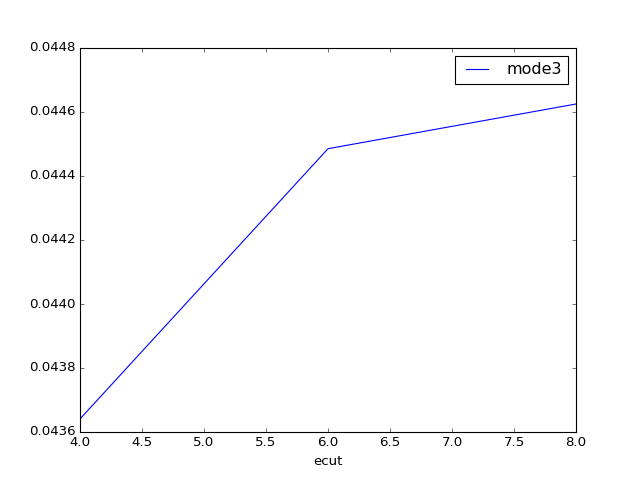

In [17]:
frame.plot(x="ecut", y="mode3")

At this point, we can call `frame.plot` inside a `for` loop to analyze 
all the phonon modes at the $\Gamma$ point:  

In [39]:
#for key in sorted(frame.keys()): 
#    if not key.startswith("mode"): continue
#    frame.plot(x="ecut", y=key, title=key, legend=False)

This convergence study at $\Gamma$ has thus revealed that our pseudos requires 
an $ecut >= 6 Ha$ to get reasonably converged phonon frequencies at $\Gamma$.
In what follows, we assume that also the modes at the other $q$-points present a similar
convergence behaviour and we use $ecut=6$ to keep the computational cost low. 

Tip: If you want to collect the phonon modes in a grid, you have to play a bit with the matplotlib API.
To create a grid of `(2 x 3)` subsplots:

<IPython.core.display.Javascript object>


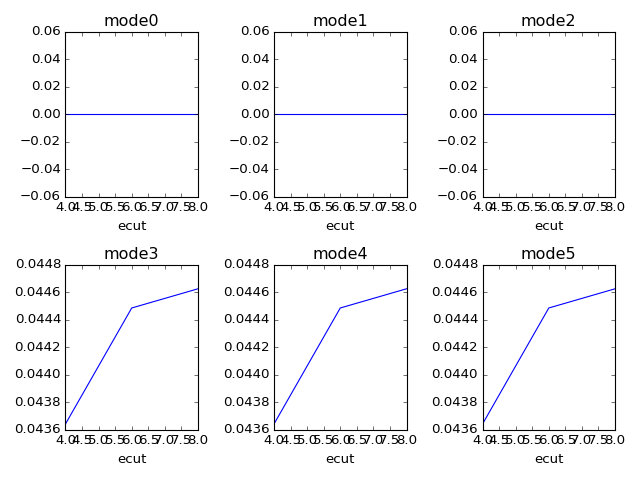

In [38]:
import matplotlib.pyplot as plt
figure, ax_list = plt.subplots(nrows=2, ncols=3)

modes = [k for k in frame.keys() if k.startswith("mode")]

for mode, ax in zip(modes, ax_list.ravel()):
    # plot mode on this AxesSubplot
    frame.plot(x="ecut", y=mode, title=mode, ax=ax, legend=False)
figure.tight_layout()

# Computing the phonon band structure of $AlAs$

In this paragraph, we use AbiPy to perform a full phonon band structure calculation.
First of all, we have to generate an `AbinitInput` for the GS-SCF step with the value of `ecut` found in the previous convergence study:

In [20]:
scf_input = make_scf_input(ecut=6, ngkpt=(4, 4, 4))

Now we call the factory function `PhononFlow.from_scf_input`
to build a `Flow` that computes all the independent atomic perturbations on a (2, 2, 2) $q$-mesh.
The optional argument `with_becs` instructs the code to include the response to a 
macroscopic electric field so that we will have access to the Born effective charges:

In [21]:
flow_phbands = flowapi.PhononFlow.from_scf_input("flow_alas_phonons", scf_input, 
                                                 ph_ngqpt=(2, 2, 2), with_becs=True)

Note that there are a lot of things happening under the hood here.

First of all, AbiPy generates `PhononTasks` only for the $q$-points in the 
irreducible wedge of the Brillouin zone corresponding to `ph_ngqpt`.
Moreover, for a given $q$-point, only the irreducible atomic perturbations are explictly computed
since the other atomic perturbations can be recostructed by symmetry.
Fortunately you don't have to care about all these technical details as AbiPy and Abinit 
will automate the whole procedure.

Remember that the $q$-point mesh cannot be chosen arbitrarily
since all $q$ wavevectors should connect two $k$ points of the grid used for the electrons.

Now we can finally plot our `PhononFlow`:

In [22]:
flow_phbands.plot_networkx()

and run it with:

In [23]:
%%capture 
# The previous line discards the output in ipython notebooks
flow_phbands.make_scheduler().start()

0

In [24]:
flow_phbands.show_summary()


Status       Count
---------  -------
Completed       12

<PhononFlow, node_id=81311, workdir=flow_alas_phonons>, num_tasks=12, all_ok=True



Our flow is completed and we have the final DDB file with all the $q$-points and all the independent atomic perturbations. 
Let's open this DDB file with:

In [25]:
ddb = flow_phbands.open_final_ddb()
ddb

<DdbFile, flow_alas_phonons/outdata/out_DDB>

The `DdbFile` object provides an easy-to-use interface that invokes `anaddb` to post-process
the data stored in the DDB file.

`anacompare_phdos`, for example, computes the phonon DOS with different $q$-meshes.
Each mesh is defined by a single integer, `nqsmall`, that gives the number of 
divisions used to sample the smallest reciprocal lattice vector. 
The number of divisions along the other directions are chosen so that proportions are preserved:

Computing 5 phonon DOS with 4 threads
 Delta(Phdos[0] - Phdos[4]) / Phdos[4]: 0.955367
 Delta(Phdos[1] - Phdos[4]) / Phdos[4]: 0.694487
 Delta(Phdos[2] - Phdos[4]) / Phdos[4]: 0.419208
 Delta(Phdos[3] - Phdos[4]) / Phdos[4]: 0.240976


<IPython.core.display.Javascript object>


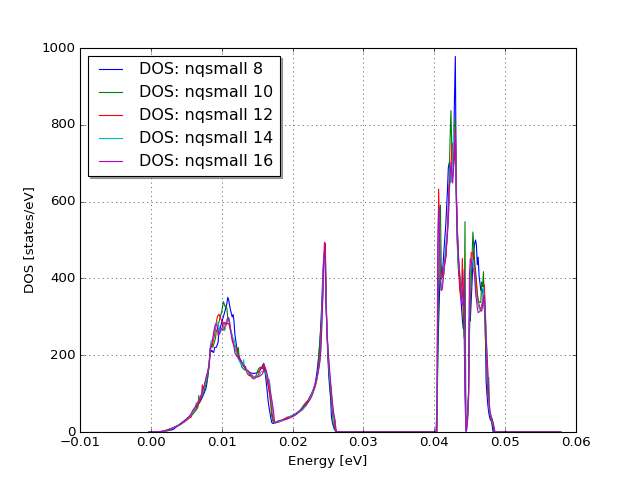

In [26]:
c = ddb.anacompare_phdos(nqsmalls=[8, 10, 12, 14, 16])
figure = c.plotter.plot()

A 16x16x16 $q$-mesh with the tethraedron method gives a well converged phonon DOS.

To function `anaget_phbst_and_phdos_files` allows one to compute the phonon band structure on an automatically defined $q$-path as well as the the phonon DOS:

In [27]:
phbst_file, phdos_file = ddb.anaget_phbst_and_phdos_files(ndivsm=10, nqsmall=16)

# Extract the phonon bands and the phonon DOS from phbst_file and phdos_file
phbands = phbst_file.phbands 
phdos = phdos_file.phdos

To plot the bands with matplotlib:

<IPython.core.display.Javascript object>


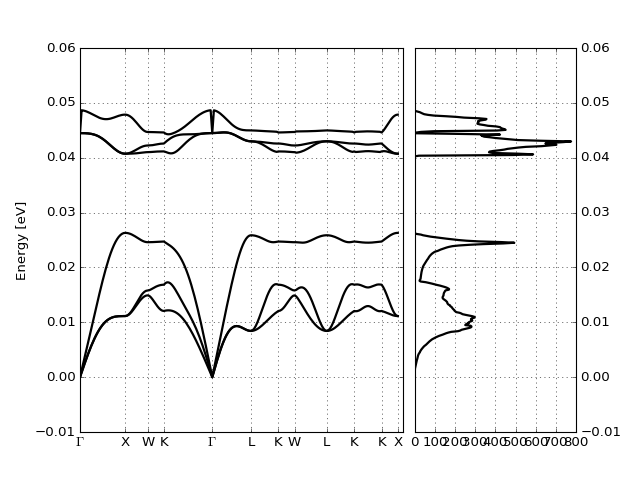

In [28]:
figure = phbands.plot()

There are two strange dips for the highest phonon band, at the $\Gamma$ point.
This is due to the lack of LO-TO splitting for the ANADDB treatment of the first list of vector. 
See also the discussion in the [second lesson](http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/lesson_rf2.html).

To plot bands and DOS on the same figure:

In [29]:
figure = phbands.plot_with_phdos(phdos)

The `PhdosFile` contains the phonon frequencies, the displacement vectors
as well as the decomposition of the total DOS in terms of the contributions due to 
the different types of atom in the unit cell.
To plot the type-projected phonon DOS:

<IPython.core.display.Javascript object>


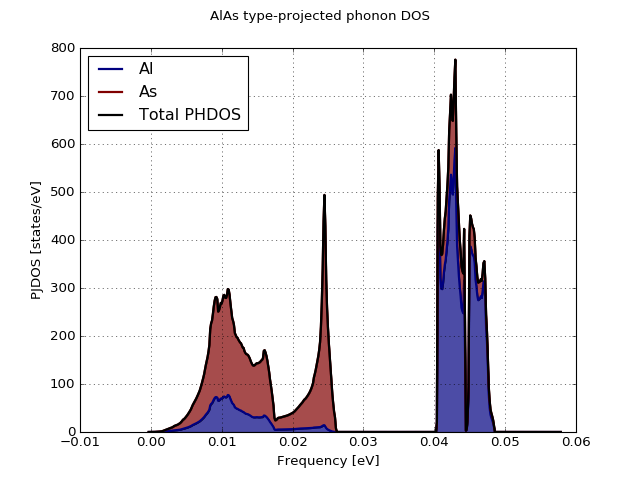

In [30]:
figure = phdos_file.plot_pjdos_type(title="AlAs type-projected phonon DOS")

## Macroscopic dielectric tensor and Born effective charges

Our calculations includes the response of the system to an external electric field.
The code below extracts the macroscopic dielectric tensor (`emacro`)
and the Born effective charges (`becs`) from the DDB file:

In [31]:
emacro, becs = ddb.anaget_emacro_and_becs()

In [32]:
emacro

(Tensor in r space.
 
 Cartesian coordinates:
 [[  1.03961652e+01   8.88178420e-16   8.88178420e-16]
  [  1.77635684e-15   1.03961652e+01   1.77635684e-15]
  [  1.77635684e-15   1.77635684e-15   1.03961652e+01]],)

In [33]:
becs

Born effective charges computed with chneut: 1
bec at site: [ 0.  0.  0.] Al
[[  2.16805280e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.16805280e+00   0.00000000e+00]
 [  4.74268488e-20   4.74268488e-20   2.16805280e+00]]

bec at site: [ 1.40364255  1.40364255  1.40364255] As
[[ -2.16805280e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.16805280e+00   0.00000000e+00]
 [ -4.74268488e-20  -4.74268488e-20  -2.16805280e+00]]

Born effective charge neutrality sum-rule with chneut: 1
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

As explained in the references, the Born effective charges must fulfill 
the charge neutrality sum-rule.
This rule is usually broken due to the discretization introduced by the FFT mesh, and `anaddb` will enforce it if `chneut` is set to 1 (default behaviour). Let's check it out!

In [34]:
becs.check_sumrule()

Born effective charge neutrality sum-rule with chneut: 1
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Let's repeat the same calculation but without enforcing the sum-rule:

In [35]:
emacro, becs_chneut0 = ddb.anaget_emacro_and_becs(chneut=0)
print(becs_chneut0)

Born effective charges computed with chneut: 0
bec at site: [ 0.  0.  0.] Al
[[  2.12729461e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.12729461e+00   0.00000000e+00]
 [  2.77676962e-20   2.77676962e-20   2.12729461e+00]]

bec at site: [ 1.40364255  1.40364255  1.40364255] As
[[ -2.20881100e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.20881100e+00   0.00000000e+00]
 [ -6.70860013e-20  -6.70860013e-20  -2.20881100e+00]]

Born effective charge neutrality sum-rule with chneut: 0
[[ -8.15163891e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -8.15163891e-02   0.00000000e+00]
 [ -3.93183050e-20  -3.93183050e-20  -8.15163891e-02]]


In [36]:
becs_chneut0.check_sumrule()

Born effective charge neutrality sum-rule with chneut: 0
[[ -8.15163891e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -8.15163891e-02   0.00000000e+00]
 [ -3.93183050e-20  -3.93183050e-20  -8.15163891e-02]]

## Exercises

    
   * Our first phonon band structure has been computed with a `(4, 4, 4)` $k$-mesh 
     for the electrons and a `(2, 2, 2)` $q$-mesh for phonons. 
     You may try to increase the density of $k$-points/$q$-points
     to see if this change affects the final results.
        
   * Why do you get an error from AbiPy if you try `ngkpt=(4, 4, 4,)` and `ngqpt=(3, 3, 3)`?
